# XGBoost模型

In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
import torch
import xgboost as xgb
from xgboost import XGBRegressor

# 資料

In [4]:
# 讀取資料
data_incomplete = pd.read_csv(
    "ExampleTrainData(IncompleteAVG)/IncompleteAvgDATA_17.csv"
)
data_complete = pd.read_csv("ExampleTrainData(AVG)/AvgDATA_17.csv")

# 轉換 Serial 為時間戳並去掉秒數
data_incomplete["Timestamp"] = data_incomplete["Serial"].astype(str).str[:-2]
data_incomplete["Timestamp"] = pd.to_datetime(
    data_incomplete["Timestamp"], format="%Y%m%d%H%M"
)
data_incomplete = data_incomplete.set_index("Timestamp")

data_complete["Timestamp"] = data_complete["Serial"].astype(str).str[:-2]
data_complete["Timestamp"] = pd.to_datetime(
    data_complete["Timestamp"], format="%Y%m%d%H%M"
)
data_complete = data_complete.set_index("Timestamp")

# 提取所需欄位
features = [
    "WindSpeed(m/s)",
    "Pressure(hpa)",
    "Temperature(°C)",
    "Humidity(%)",
    "Sunlight(Lux)",
]
target = "Power(mW)"

# 合併資料
combined_data = pd.concat(
    [data_incomplete[features + [target]], data_complete[features + [target]]]
)
combined_data = combined_data.sort_index()


# 每一天單獨處理，僅填補早上 7 點到下午 5 點的時間段
filled_data = combined_data.copy()  # 複製原始資料，這樣不會破壞原始資料
# 確保填補資料框具有欄位
for day in pd.date_range(
    start=combined_data.index.min().date(),
    end=combined_data.index.max().date(),
    freq="D",
):
    # 設定填補範圍
    start_time = day.replace(hour=7, minute=0, second=0)
    end_time = day.replace(hour=16, minute=50, second=0)
    time_range_to_fill = pd.date_range(start=start_time, end=end_time, freq="10T")

    # 跳過 end_time 早於早上 9 點的天數
    if end_time < day.replace(hour=9, minute=0, second=0):
        continue

    # 在填補範圍內進行移動平均值補缺
    for time in time_range_to_fill:
        if time not in filled_data.index:
            # 將該時間點的缺失值填充為滑動窗口的均值
            # 獲取最近的五個時間點進行平均計算
            filled_data.loc[time] = 0
            window = filled_data.loc[:time].tail(4)  # 取出之前五個有效數據點
            if not window.empty:
                filled_data.loc[time] = window.mean()
            else:
                filled_data.loc[time] = 0  # 如果沒有有效數據，用 0 填補

# 最終的 filled_data 是僅針對早上 7 點到下午 5 點補全的資料
combined_data = filled_data.sort_index()


# 整理 x_train 和 y_train
x_train_list = []
y_train_list = []
review_day = 0

# 假設 combined_data 已經存在
day_count = 0
for day in pd.date_range(
    start=combined_data.index.min(), end=combined_data.index.max(), freq="D"
):
    # 從第n天開始計算
    if day_count < review_day:
        day_count += 1
        continue

    # 取得當天的資料
    day_data = combined_data.loc[
        day : day + timedelta(days=1) - timedelta(seconds=1)
    ]  # 取該天的資料

    # 確保取出的時間範圍是有效的
    morning_range = pd.date_range(
        start=day.replace(hour=7, minute=0, second=0),
        end=day.replace(hour=8, minute=50, second=0),
        freq="T",
    )
    evening_range = pd.date_range(
        start=day.replace(hour=9, minute=0, second=0),
        end=day.replace(hour=17, minute=0, second=0),
        freq="T",
    )

    # 提取當天 7點到9點的特徵資料
    x_day = day_data.loc[day_data.index.isin(morning_range)]

    # 9點到下午5點的目標資料
    y_day = day_data.loc[day_data.index.isin(evening_range), "Power(mW)"]

    # 加入前n天的完整資料
    for i in range(1, review_day + 1):
        prev_day = day - timedelta(days=i)
        prev_day_data = combined_data.loc[
            prev_day : prev_day + timedelta(days=1) - timedelta(seconds=1)
        ]

        # 如果前一天資料為空，跳過
        if prev_day_data.empty:
            break

        x_day = pd.concat([prev_day_data[features], x_day[features]])
    x_day = np.array(x_day)

    # 確保資料是非空的，然後儲存
    if x_day.size > 0 and y_day.size > 0:
        x_train_list.append(x_day[:, 1:])  # 儲存每個時間段的特徵值
        y_train_list.append(y_day)  # 儲存對應的目標值

# 訓練集和測試集

In [5]:
# 將 list 合併並轉換為 Tensor
x_train = np.array(x_train_list, dtype=np.float32)  # 確保資料形狀一致
y_train = np.array(y_train_list, dtype=np.float32)

x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)


# # 標準化
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# 對特徵和目標進行標準化
x_train_standardized = scaler_features.fit_transform(
    x_train.reshape(-1, x_train.shape[-1])
).reshape(x_train.shape)

y_train_standardized = scaler_target.fit_transform(
    y_train.reshape(-1, 1)
).reshape(y_train.shape)

# 轉換為 Tensor
x_train_tensor = torch.tensor(x_train_standardized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_standardized, dtype=torch.float32)

print(f"x_train shape: {x_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")
# (193, 72, 4)  (193, 48)

# 將 x_train_tensor 和 y_train_tensor 展平為 2D 格式
x_data = x_train_tensor.numpy().reshape(x_train_tensor.shape[0], -1)
y_data = y_train_tensor.numpy()

print(f"x_data shape: {x_data.shape}")  # (193, 288)
print(f"y_data shape: {y_data.shape}")  # (193, 48)



# 預測訓練集
test_data = pd.read_csv("ExampleTestData/upload.csv")
test_data.columns = ["date/time/id", "answer"]
date_list = []
time_list = []
station_id_list = []

for index in range(len(test_data)):
    date = str(test_data["date/time/id"][index])[:8]
    time = str(test_data["date/time/id"][index])[8:12]
    station_id = str(test_data["date/time/id"][index])[12:]

    date_list.append(date)
    time_list.append(time)
    station_id_list.append(station_id)

test_data["date"] = date_list
test_data["time"] = time_list
test_data["id"] = station_id_list

test_data.drop(["date/time/id"], axis=1, inplace=True)
station_filter = test_data["id"] == "17"
test_data = test_data[station_filter]
test_date = test_data["date"].value_counts().index

x_test_list = []
y_test_list = []
for day in pd.to_datetime(test_date):
    # 取得當天的資料
    day_data = combined_data.loc[
        day : day + timedelta(days=1) - timedelta(seconds=1)
    ]  # 取該天的資料

    # 確保取出的時間範圍是有效的
    morning_range = pd.date_range(
        start=day.replace(hour=7, minute=0, second=0),
        end=day.replace(hour=8, minute=50, second=0),
        freq="T",
    )
    evening_range = pd.date_range(
        start=day.replace(hour=9, minute=0, second=0),
        end=day.replace(hour=17, minute=0, second=0),
        freq="T",
    )

    # 提取當天 7點到9點的特徵資料
    x_day = day_data.loc[day_data.index.isin(morning_range)]


    # 加入前n天的完整資料
    for i in range(1, review_day + 1):
        prev_day = day - timedelta(days=i)
        prev_day_data = combined_data.loc[
            prev_day : prev_day + timedelta(days=1) - timedelta(seconds=1)
        ]

        # 如果前一天資料為空，跳過
        if prev_day_data.empty:
            break

        x_day = pd.concat([prev_day_data[features], x_day[features]])
    x_day = np.array(x_day)

    # 確保資料是非空的，然後儲存
    if x_day.size > 0:
        x_test_list.append(x_day[:, 1:])  # 儲存每個時間段的特徵值

x_test_tensor = torch.tensor(x_test_list, dtype=torch.float32)
y_test_tensor = torch.tensor(test_data["answer"].values, dtype=torch.float32)

x_test_standardized = scaler_features.transform(
    x_test_tensor.numpy().reshape(-1, x_test_tensor.shape[-1])
).reshape(x_test_tensor.shape)

x_test_flattened = x_test_standardized.reshape(x_test_standardized.shape[0], -1)

x_train shape: torch.Size([194, 12, 5])
y_train shape: torch.Size([194, 48])
x_data shape: (194, 60)
y_data shape: (194, 48)


C:\Users\mow20\AppData\Local\Temp\ipykernel_10388\1271742834.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  x_test_tensor = torch.tensor(x_test_list, dtype=torch.float32)


# 模型建置

In [6]:
# 定義模型參數
model_params = {
    'objective': 'reg:squarederror',
    'max_depth': 1,
    'learning_rate': 0.01,
    'n_estimators': 300,
    'subsample': 0.1,
    'colsample_bytree': 0.25
}

# 滑動窗口分割
n_splits = 5  # 設定交叉驗證的分割數
tscv = TimeSeriesSplit(n_splits=n_splits)

# 儲存每個分割的結果
validation_scores = []
best_iterations = []

# 交叉驗證過程
for fold, (train_index, val_index) in enumerate(tscv.split(x_data)):
    print(f"\nFold {fold + 1}/{n_splits}")
    
    # 提取訓練集與驗證集
    x_train, x_valid = x_data[train_index], x_data[val_index]
    y_train, y_valid = y_data[train_index], y_data[val_index]
    
    # 建立模型
    model = XGBRegressor(**model_params)
    
    # 訓練模型，使用早停法
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        early_stopping_rounds=20,  # 若 10 回合未改善，停止訓練
        verbose=True
    )
    
    # 儲存驗證結果
    y_pred = model.predict(x_valid)
    score = root_mean_squared_error(y_valid, y_pred)  # 使用 RMSE 評估
    validation_scores.append(score)
    
    # 儲存最佳回合數
    if hasattr(model, 'best_ntree_limit') and model.best_ntree_limit is not None:
        best_iterations.append(model.best_ntree_limit)
    else:
        best_iterations.append(model.n_estimators)  # 如果沒有 best_ntree_limit，使用 n_estimators
    
    print(f"Validation RMSE: {score}")

# 移除 model_params 中的 n_estimators
model_params_without_n_estimators = {key: value for key, value in model_params.items() if key != 'n_estimators'}

# 使用所有資料進行最終訓練
final_model = XGBRegressor(
    **model_params_without_n_estimators,
    n_estimators=int(np.mean(best_iterations))  # 使用平均的最佳迭代次數
)

# 訓練最終模型
final_model.fit(x_data, y_data)
print(f"Average Validation RMSE: {np.mean(validation_scores):.2f}")
print(f"Average Best Iteration: {int(np.mean(best_iterations))}")


Fold 1/5
[0]	validation_0-rmse:0.21977
[1]	validation_0-rmse:0.21943
[2]	validation_0-rmse:0.21906
[3]	validation_0-rmse:0.21869
[4]	validation_0-rmse:0.21837
[5]	validation_0-rmse:0.21806
[6]	validation_0-rmse:0.21781
[7]	validation_0-rmse:0.21749
[8]	validation_0-rmse:0.21709
[9]	validation_0-rmse:0.21676


c:\Users\mow20\anaconda3\envs\ml1131\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.21639
[11]	validation_0-rmse:0.21607
[12]	validation_0-rmse:0.21572
[13]	validation_0-rmse:0.21537
[14]	validation_0-rmse:0.21504
[15]	validation_0-rmse:0.21475
[16]	validation_0-rmse:0.21449
[17]	validation_0-rmse:0.21407
[18]	validation_0-rmse:0.21369
[19]	validation_0-rmse:0.21345
[20]	validation_0-rmse:0.21326
[21]	validation_0-rmse:0.21295
[22]	validation_0-rmse:0.21267
[23]	validation_0-rmse:0.21244
[24]	validation_0-rmse:0.21220
[25]	validation_0-rmse:0.21184
[26]	validation_0-rmse:0.21149
[27]	validation_0-rmse:0.21132
[28]	validation_0-rmse:0.21105
[29]	validation_0-rmse:0.21082
[30]	validation_0-rmse:0.21053
[31]	validation_0-rmse:0.21040
[32]	validation_0-rmse:0.21025
[33]	validation_0-rmse:0.21010
[34]	validation_0-rmse:0.20979
[35]	validation_0-rmse:0.20954
[36]	validation_0-rmse:0.20934
[37]	validation_0-rmse:0.20917
[38]	validation_0-rmse:0.20900
[39]	validation_0-rmse:0.20893
[40]	validation_0-rmse:0.20866
[41]	validation_0-rmse:0.20849
[42]	val

c:\Users\mow20\anaconda3\envs\ml1131\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:0.19632
[30]	validation_0-rmse:0.19589
[31]	validation_0-rmse:0.19539
[32]	validation_0-rmse:0.19491
[33]	validation_0-rmse:0.19446
[34]	validation_0-rmse:0.19396
[35]	validation_0-rmse:0.19351
[36]	validation_0-rmse:0.19310
[37]	validation_0-rmse:0.19265
[38]	validation_0-rmse:0.19212
[39]	validation_0-rmse:0.19169
[40]	validation_0-rmse:0.19125
[41]	validation_0-rmse:0.19079
[42]	validation_0-rmse:0.19045
[43]	validation_0-rmse:0.19005
[44]	validation_0-rmse:0.18959
[45]	validation_0-rmse:0.18913
[46]	validation_0-rmse:0.18868
[47]	validation_0-rmse:0.18837
[48]	validation_0-rmse:0.18801
[49]	validation_0-rmse:0.18754
[50]	validation_0-rmse:0.18713
[51]	validation_0-rmse:0.18673
[52]	validation_0-rmse:0.18633
[53]	validation_0-rmse:0.18585
[54]	validation_0-rmse:0.18545
[55]	validation_0-rmse:0.18520
[56]	validation_0-rmse:0.18493
[57]	validation_0-rmse:0.18453
[58]	validation_0-rmse:0.18400
[59]	validation_0-rmse:0.18361
[60]	validation_0-rmse:0.18318
[61]	val

c:\Users\mow20\anaconda3\envs\ml1131\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-rmse:0.10785
[27]	validation_0-rmse:0.10761
[28]	validation_0-rmse:0.10738
[29]	validation_0-rmse:0.10717
[30]	validation_0-rmse:0.10696
[31]	validation_0-rmse:0.10664
[32]	validation_0-rmse:0.10635
[33]	validation_0-rmse:0.10611
[34]	validation_0-rmse:0.10593
[35]	validation_0-rmse:0.10572
[36]	validation_0-rmse:0.10547
[37]	validation_0-rmse:0.10525
[38]	validation_0-rmse:0.10503
[39]	validation_0-rmse:0.10486
[40]	validation_0-rmse:0.10471
[41]	validation_0-rmse:0.10449
[42]	validation_0-rmse:0.10426
[43]	validation_0-rmse:0.10401
[44]	validation_0-rmse:0.10392
[45]	validation_0-rmse:0.10377
[46]	validation_0-rmse:0.10352
[47]	validation_0-rmse:0.10331
[48]	validation_0-rmse:0.10315
[49]	validation_0-rmse:0.10309
[50]	validation_0-rmse:0.10288
[51]	validation_0-rmse:0.10256
[52]	validation_0-rmse:0.10248
[53]	validation_0-rmse:0.10252
[54]	validation_0-rmse:0.10245
[55]	validation_0-rmse:0.10231
[56]	validation_0-rmse:0.10216
[57]	validation_0-rmse:0.10191
[58]	val

c:\Users\mow20\anaconda3\envs\ml1131\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:0.13746
[32]	validation_0-rmse:0.13710
[33]	validation_0-rmse:0.13671
[34]	validation_0-rmse:0.13637
[35]	validation_0-rmse:0.13598
[36]	validation_0-rmse:0.13558
[37]	validation_0-rmse:0.13519
[38]	validation_0-rmse:0.13480
[39]	validation_0-rmse:0.13445
[40]	validation_0-rmse:0.13417
[41]	validation_0-rmse:0.13388
[42]	validation_0-rmse:0.13361
[43]	validation_0-rmse:0.13325
[44]	validation_0-rmse:0.13298
[45]	validation_0-rmse:0.13271
[46]	validation_0-rmse:0.13239
[47]	validation_0-rmse:0.13209
[48]	validation_0-rmse:0.13179
[49]	validation_0-rmse:0.13158
[50]	validation_0-rmse:0.13130
[51]	validation_0-rmse:0.13103
[52]	validation_0-rmse:0.13076
[53]	validation_0-rmse:0.13052
[54]	validation_0-rmse:0.13027
[55]	validation_0-rmse:0.13013
[56]	validation_0-rmse:0.12998
[57]	validation_0-rmse:0.12979
[58]	validation_0-rmse:0.12966
[59]	validation_0-rmse:0.12946
[60]	validation_0-rmse:0.12932
[61]	validation_0-rmse:0.12917
[62]	validation_0-rmse:0.12900
[63]	val

c:\Users\mow20\anaconda3\envs\ml1131\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:0.21478
[31]	validation_0-rmse:0.21410
[32]	validation_0-rmse:0.21361
[33]	validation_0-rmse:0.21303
[34]	validation_0-rmse:0.21242
[35]	validation_0-rmse:0.21185
[36]	validation_0-rmse:0.21131
[37]	validation_0-rmse:0.21068
[38]	validation_0-rmse:0.21012
[39]	validation_0-rmse:0.20964
[40]	validation_0-rmse:0.20926
[41]	validation_0-rmse:0.20880
[42]	validation_0-rmse:0.20835
[43]	validation_0-rmse:0.20782
[44]	validation_0-rmse:0.20730
[45]	validation_0-rmse:0.20685
[46]	validation_0-rmse:0.20636
[47]	validation_0-rmse:0.20588
[48]	validation_0-rmse:0.20542
[49]	validation_0-rmse:0.20503
[50]	validation_0-rmse:0.20463
[51]	validation_0-rmse:0.20428
[52]	validation_0-rmse:0.20391
[53]	validation_0-rmse:0.20352
[54]	validation_0-rmse:0.20302
[55]	validation_0-rmse:0.20263
[56]	validation_0-rmse:0.20229
[57]	validation_0-rmse:0.20191
[58]	validation_0-rmse:0.20154
[59]	validation_0-rmse:0.20114
[60]	validation_0-rmse:0.20081
[61]	validation_0-rmse:0.20055
[62]	val

# 模型結果

預測結果: [ 55.334705  100.599106  256.52106   531.1136    591.1714    607.19617
 624.983     697.225     655.26434   596.5248    578.73114   189.91081
 183.78496   202.09227   261.1614    281.21106   165.65741   136.3096
 158.33931   134.08154   184.59283   170.29189    97.23421    83.774
  88.477844   54.978905   51.69745    50.523525   17.877708   36.971973
  39.194195   28.68957    28.008804   24.137785   20.938808   18.321047
  19.912804   17.014591   14.719436   14.705585   14.140631   13.055883
  12.213514   12.127381   11.964979   11.695967   11.355914   11.087121
  38.700954   40.939808   78.87572   122.972305  142.23631   100.885025
 127.309494  146.41966   155.4344    155.62494   165.54837   123.04364
 127.14685   130.4759    116.970215  141.70714   123.455765  106.63694
  72.540634  144.76573   103.53177   120.14479    93.959045  108.631485
  98.99646    81.06929    66.696236   56.992992   58.434803   45.869686
  40.97393    44.934338   54.06764    36.519543   29.514078   30.71

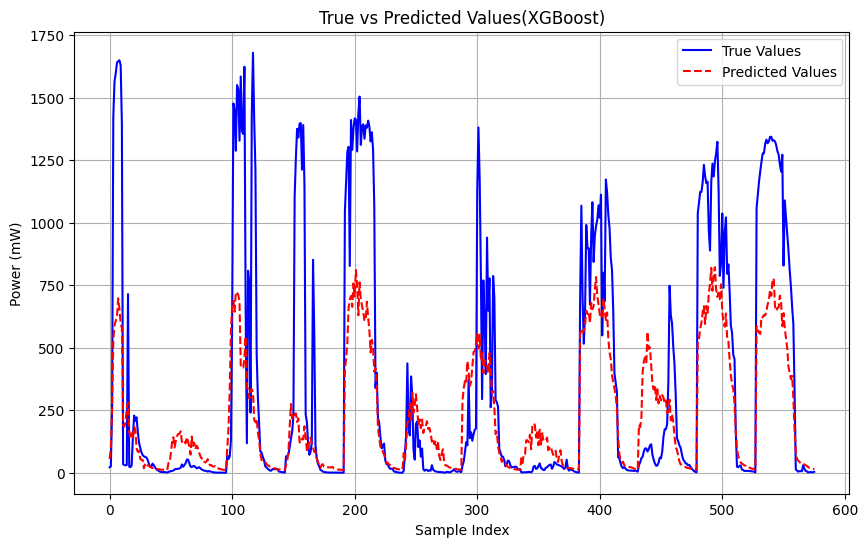

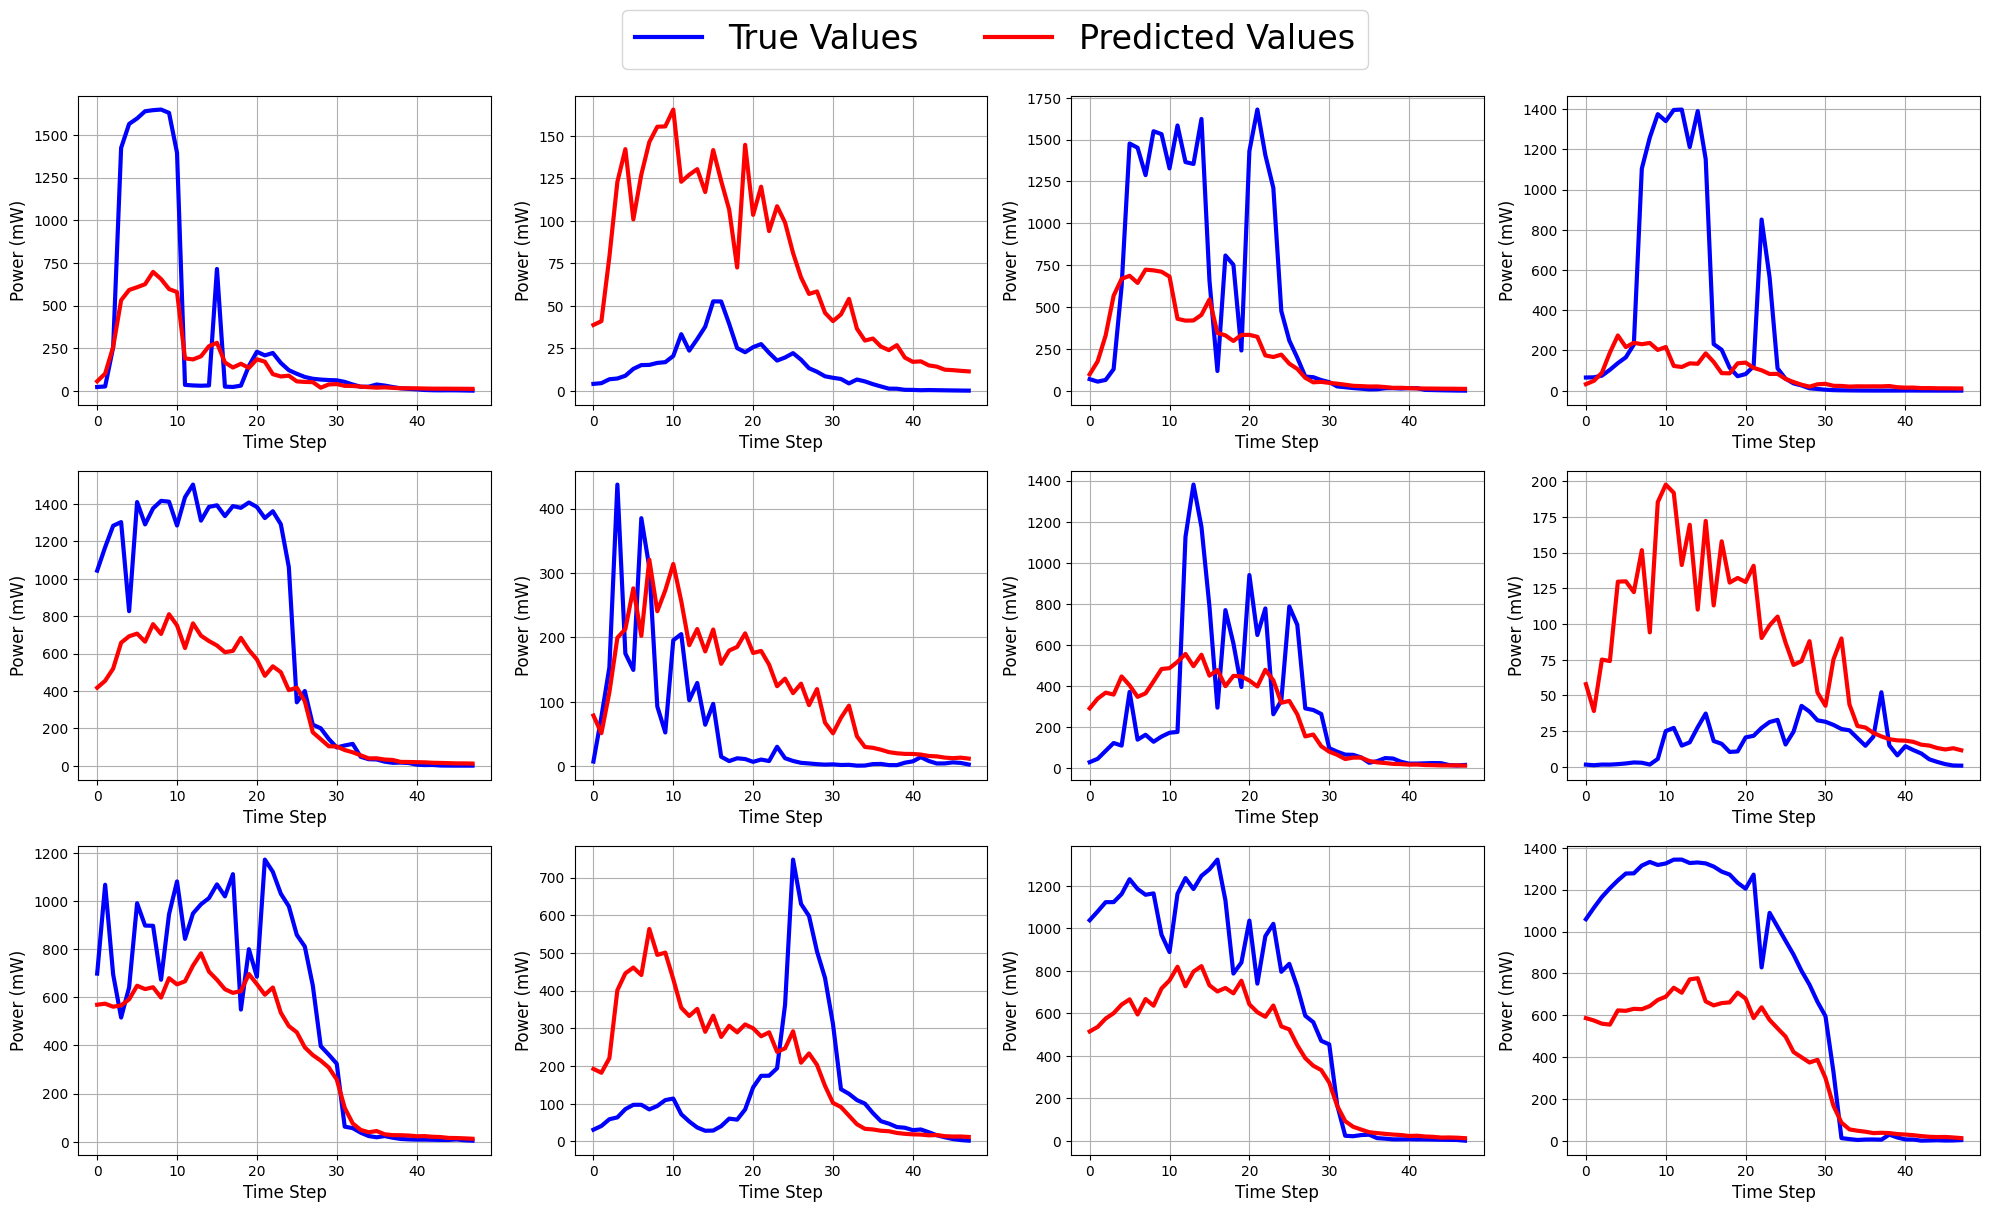

In [8]:
# 使用模型進行預測
y_pred = final_model.predict(x_test_flattened)

# 反標準化
y_pred_original = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# 查看預測結果
print("預測結果:", y_pred_original)

def calculate_total_score(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.numpy()
    return np.sum(np.abs(y_pred - y_true))

print(calculate_total_score(y_test_tensor, y_pred_original))

import matplotlib.pyplot as plt

# 轉換為 NumPy 數組
y_test_numpy = y_test_tensor.numpy()
y_pred_numpy = y_pred_original

# 視覺化預測結果 vs 實際結果
plt.figure(figsize=(10, 6))
plt.plot(y_test_numpy, label='True Values', color='blue')
plt.plot(y_pred_numpy, label='Predicted Values', color='red', linestyle='--')
plt.title('True vs Predicted Values(XGBoost)')
plt.xlabel('Sample Index')
plt.ylabel('Power (mW)')
plt.legend()
plt.grid(True)
plt.show()


fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))  # 3行4列的子圖
axes = axes.flatten()  # 展平成一維數組，方便索引

# 分成每一天
for i in range(12):
    start_idx = i * 48
    end_idx = (i + 1) * 48
    
    # 實際值預測值
    y_test_day = y_test_numpy[start_idx:end_idx]
    y_pred_day = y_pred_numpy[start_idx:end_idx]
    
    # 畫圖
    axes[i].plot(y_test_day, label='True Values', color='blue', linewidth=3)
    axes[i].plot(y_pred_day, label='Predicted Values', color='red', linewidth=3)
    axes[i].set_xlabel('Time Step', fontsize=12)  # x軸標籤
    axes[i].set_ylabel('Power (mW)', fontsize=12)  # y軸標籤
    axes[i].grid(True)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=24, ncol=2, bbox_to_anchor=(0.5, 1.02))

# 子圖間距
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()